In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
# torchvision 数据集的输出是范围为 [0， 1] 的 PILImage 图像。 我们将它们转换为归一化范围 [-1， 1] 的张量。
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


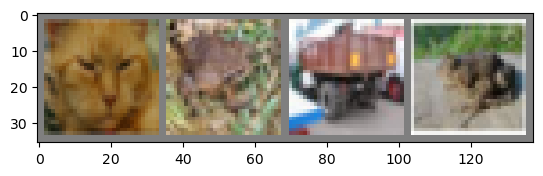

cat   frog  truck frog 


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    # img = img / 2 + 0.5: 这行代码对输入的图像数据进行反归一化操作。在训练过程中，图像数据通常被归一化到 [0, 1] 的范围内。这行代码将图像数据乘以0.5然后加上0.5，将其反归一化回原始的 [0, 1] 范围内。
    img = img / 2 + 0.5     # unnormalize
    #npimg = img.numpy(): 这行代码将 PyTorch 张量 img 转换为 NumPy 数组 npimg。这样做是因为 Matplotlib 库通常使用 NumPy 数组来处理图像数据。
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
# 获取一个批次的数据，也就是4张图片
#将训练数据加载器 trainloader 转换为一个迭代器 dataiter
dataiter = iter(trainloader)
# 使用 next() 函数逐个获取数据批次。
images, labels = next(dataiter) 


# show images
#torchvision.utils.make_grid(images): 这个函数会将图像张量 images 中的多个图像按照网格排列，并返回一个包含这些图像的网格图像张量。
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [17]:
# 定义卷积神经网络
import torch.nn as nn
import torch.nn.functional as F




class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
# 使用gpu
net = net.to(device)

In [18]:
# 定义损失函数和优化器
import torch.optim as optim
# 交叉熵
criterion = nn.CrossEntropyLoss()# (交叉熵用于分类问题，均方误差用于回归）
# 使用gpu
criterion=criterion.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):#索引从0开始计数
        # get the inputs; data is a list of [inputs, labels]
        # 使用GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        # torch.Size([4, 3, 32, 32])
        # inputs_np = inputs.numpy()  # 将输入数据转换为NumPy数组
        # inputs_tensor = torch.from_numpy(inputs_np)
        # print(inputs_tensor.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.141
[1,  4000] loss: 1.804
[1,  6000] loss: 1.669
[1,  8000] loss: 1.569
[1, 10000] loss: 1.495
[1, 12000] loss: 1.445
[2,  2000] loss: 1.380
[2,  4000] loss: 1.361
[2,  6000] loss: 1.326
[2,  8000] loss: 1.334
[2, 10000] loss: 1.273
[2, 12000] loss: 1.260
Finished Training


In [20]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

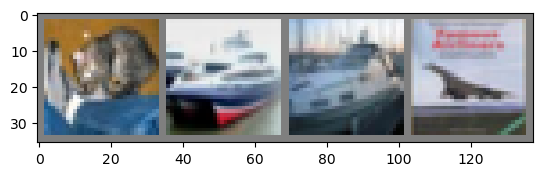

GroundTruth:  cat   ship  ship  plane


In [21]:
# 在测试数据上测试网络
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [25]:
# 加载模型
PATH = './cifar_net.pth'
net = Net()
net = net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [26]:
# 现在让我们看看神经网络认为上面的这些例子是什么
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   ship 


In [32]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 使用GPU
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # print(labels.size(0)) # 4
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
# Accuracy of the network on the 10000 test images: 58 %

Accuracy of the network on the 10000 test images: 56 %


In [34]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 使用GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            print(predictions)
            print(labels)
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    
'''
Accuracy for class: plane is 61.8 %
Accuracy for class: car   is 76.7 %
Accuracy for class: bird  is 47.6 %
Accuracy for class: cat   is 46.3 %
Accuracy for class: deer  is 47.5 %
Accuracy for class: dog   is 37.7 %
Accuracy for class: frog  is 59.8 %
Accuracy for class: horse is 72.7 %
Accuracy for class: ship  is 74.3 %
Accuracy for class: truck is 58.0 %


'''

tensor([3, 1, 1, 8], device='cuda:0')
tensor([3, 8, 8, 0], device='cuda:0')
tensor([3, 1, 1, 8], device='cuda:0')
tensor([3, 8, 8, 0], device='cuda:0')
tensor([3, 1, 1, 8], device='cuda:0')
tensor([3, 8, 8, 0], device='cuda:0')
tensor([3, 1, 1, 8], device='cuda:0')
tensor([3, 8, 8, 0], device='cuda:0')
tensor([6, 6, 1, 6], device='cuda:0')
tensor([6, 6, 1, 6], device='cuda:0')
tensor([6, 6, 1, 6], device='cuda:0')
tensor([6, 6, 1, 6], device='cuda:0')
tensor([6, 6, 1, 6], device='cuda:0')
tensor([6, 6, 1, 6], device='cuda:0')
tensor([6, 6, 1, 6], device='cuda:0')
tensor([6, 6, 1, 6], device='cuda:0')
tensor([5, 1, 4, 9], device='cuda:0')
tensor([3, 1, 0, 9], device='cuda:0')
tensor([5, 1, 4, 9], device='cuda:0')
tensor([3, 1, 0, 9], device='cuda:0')
tensor([5, 1, 4, 9], device='cuda:0')
tensor([3, 1, 0, 9], device='cuda:0')
tensor([5, 1, 4, 9], device='cuda:0')
tensor([3, 1, 0, 9], device='cuda:0')
tensor([5, 7, 9, 1], device='cuda:0')
tensor([5, 7, 9, 8], device='cuda:0')
tensor([5, 7

KeyboardInterrupt: 

In [ ]:
import torch
torch.cuda.is_available()